In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
from cycler import cycler

def CONSISTENCY(A1,B1,D1,A2,B2,D2):
    n1 = A1.shape[0]
    M1 = np.vstack([np.hstack([A1, B1.T]),
                    np.hstack([B1, D1])])
    M2 = np.vstack([np.hstack([D2, B2]),
                    np.hstack([B2.T, A2])])
    M = np.linalg.inv(M1)@M2.T
    evals, evecs = scipy.sparse.linalg.eigs(M,k=n1+1,which='SM')
    idx = np.argsort(np.abs(evals))
    evals = evals[idx]
    evecs = evecs[:,idx]
    Y,X = evecs[:n1,:n1], evecs[n1:,:n1]
    L = np.linalg.solve(Y.T,X.T).T#X@np.linalg.inv(Y)
    def LFT1(L):
        return -np.linalg.solve(A1+L.T@B1,B1.T+L.T@D1)
    def LFT2(G):
        return -np.linalg.solve(A2+G.T@B2,B2.T+G.T@D2)

    G = LFT1(L)  
    error = ''
    if not np.allclose(L,LFT2(G)):
        error += 'not a fixed point; '
    
    # eig1,_ = scipy.sparse.linalg.eigs(A1+L.T@B1,k=1,which='SR')
    # eig2,_ = scipy.sparse.linalg.eigs(A2+G.T@B2,k=1,which='SR')
    # if not np.all(np.real(np.hstack([eig1,eig2]))>0):
    #     error += 'not stable in action space; '
    if np.isclose((evals[n1-1]),np.conj(evals[n1]),atol=1e-6):
        error += 'conjugate pair in the gap; '

    if np.isclose(np.abs(evals[n1-1]),np.abs(evals[n1]),atol=3e-3):
        error += 'not stable in policy space; '
    else:
        print('gap:',np.abs(evals[n1])-np.abs(evals[n1-1]))
        #print('Warning! LFT unstable!', evals[n1-1], evals[n1])
        
    return (L,G,LFT1,LFT2),error


def grad(xi, xj, Li, A, B, D, b, d):
    return (A+Li.T@B)@xi + (B.T+Li.T@D)@xj + b + Li.T@d
    
def solve_eq(L, G, A1, B1, D1, b1, d1, A2, B2, D2, b2, d2):
    n1 = A1.shape[0]
    EQ = -np.linalg.solve(np.vstack([np.hstack([A1+L.T@B1,B1.T+L.T@D1]),
                                     np.hstack([B2.T+G.T@D2,A2+G.T@B2])]),
                          np.hstack([b1 + L.T@d1,
                                     b2 + G.T@d2]))
    return EQ[:n1], EQ[n1:]


default_cycler = (cycler(color=['#332288','#117733','#44AA99','#88CCEE','#CC6677','#AA4499','#882255']))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)


seed: 0
gap: 0.024968545443687984
seed: 1
gap: 0.006659153250835548
seed: 2
gap: 0.0044524074517733325
seed: 3
gap: 0.009968641334215045
seed: 4
ERROR: not stable in policy space; 
seed: 5
gap: 0.004078913366073023


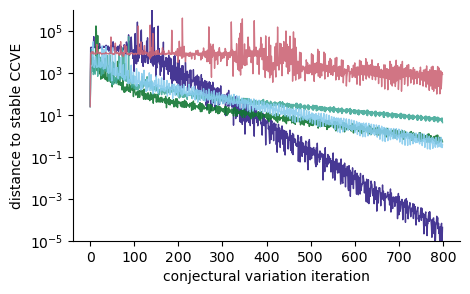

In [17]:
fig,ax = plt.subplots(figsize=(5,3))
count = 0
for seed in range(1000000):
    n1 = 202
    n2 = 303

    np.random.seed(seed)
    A1 = np.eye(n1)
    B1 = np.round(np.random.rand(n2,n1),1)

    D1 = np.eye(n2)/3
    b1 = np.zeros(n1)
    d1 = np.zeros(n2)

    A2 = np.eye(n2)
    B2 = -np.round(np.random.rand(n1,n2),1)

    D2 = np.eye(n1)/4

    b2 = np.ones(n2)
    d2 = np.ones(n1)
    print('seed:', seed)
    (L,G,LFT1,LFT2),error=CONSISTENCY(A1,B1,D1,A2,B2,D2)
    if error:
        print('ERROR:',error)
        #continue
        continue
    LFT = lambda L: LFT2(LFT1(L))
    L,G
    CCVE = solve_eq(L,G,A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)
    NE = solve_eq(np.zeros((n2,n1)),np.zeros((n1,n2)),A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)
    T = 800
    L_ = np.zeros((T,*L.shape))
    L_[0] = np.real(L)+.1*np.random.randn(*L.shape)
    for t in range(T-1):
        L_[t+1] = LFT(L_[t])
    ax.plot(np.linalg.norm(L_-L,axis=(1,2)),alpha=0.9)

    count += 1
    if count >= 5:
        break
ax.set_yscale('log')
ax.set(xlabel='conjectural variation iteration')
ax.set(ylabel='distance to stable CCVE')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set(ylim=[10e-6,10e5])
fig.savefig('2023lcss-202x303-norm.pdf',bbox_inches='tight')